Carry out model fitting for CLAMATO cross-correlation analysis, with Andreu Font's models. We also fit for redshift offsets.

This version is for v4 of the cross-correlation measurements and v1 (Nov 2) of the models.

In [1]:
import numpy as np
from astropy.io import ascii
import xcorrmodel

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib notebook

modeldir = '/Users/kheegan/lya/3d_recon/map2017/crosscorr/model_grid_v1/'

# Set up the grid to loop over 
deltaz_grid = np.linspace(-4., 4., num=81)
n_deltaz = len(deltaz_grid)

# Read bin edges
PiBin_fil = 'bins23_pi_0-30hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

SigEdgesVec, PiEdgesVec = np.meshgrid(SigEdges, PiEdges)

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

SigEdgesPlot = SigEdgesVec/(np.ones(np.shape(SigEdgesVec))*[cosmo.h])
PiEdgesPlot = PiEdgesVec / (np.ones(np.shape(PiEdgesVec))*[cosmo.h])


Read in all the models. This step and the rebinning step should only be done once and then subsequently read in from the saved file.

In [2]:
read_model = ascii.read(modeldir+'model_list_v1.txt',names=['modelfil'],
                        format='no_header',guess=False)

modelfils = read_model['modelfil'].data

nmodels_raw = len(modelfils)
nmodels = nmodels_raw * n_deltaz

model_arr = []
for m in modelfils:
    #print("Reading"+m)
    model_arr.append(xcorrmodel.XCorrModel(modeldir+m))

np.save(modeldir+'model_grid_v1.npy', model_arr)

model_arr = np.load(modeldir+'model_grid_v1.npy')

Generate rebinning indices for our desired set of delta_z

In [3]:

# Get model sigma and pi bins
PiModel = model_arr[0].rp
SigModel = model_arr[1].rt

index_vector = []

for ztmp in deltaz_grid:
    index_vector.append(xcorrmodel.rebin_model_to_xcorr(ztmp, SigModel, PiModel, 
                            SigEdges, PiEdges,verbose=False))

np.save(modeldir+'rebin_v1_to_sig10_pi23.npy',index_vector)

index_vector = np.load(modeldir+'rebin_v0_to_sig10_pi23.npy')

Define a couple of methods for fitting the grid of models, and also to plot the results

In [4]:
def fit_lotsa_models(xcorr_in, invcov_in, model_arr, rebin_indices, deltaz_grid, 
               survey_str = ""):
    """Method to evaluate a grid of linear cross-correlation models w.r.t. an input 
    observed x-corr and corresponding inverse covariance. The rebin_indices (and 
    corresponding delta_z values) are used to map from the model bins to the output bins.
    
    XCorr_in and InvCov_in should already flattened on input"""
    nmodels_raw = len(model_arr)
    n_deltaz    = len(rebin_indices)
    nmodels = nmodels_raw * n_deltaz

    dtype =[('bias', 'f8'), ('sig_z', 'f8'), ('delta_z', 'f8'), 
            ('chi_sq', 'f8'), ('survey', 'U10'),('filname','U200')]

    fitresults_out = np.empty(nmodels, dtype=dtype)
    ctr = 0
    
    XCorrFlat = xcorr_in
    InvCov = invcov_in
    
    for dz_tmp, indices in zip(deltaz_grid, rebin_indices):
        for modeltmp in model_arr:
            modeltmp2d = modeltmp.rebin2d(indices, SigEdges, PiEdges)
            modeltmpflat = modeltmp2d.reshape(modeltmp2d.size)
            DeltaVec = XCorrFlat-modeltmpflat
            chisq_tmp = np.dot(DeltaVec.transpose(), np.dot(InvCov, DeltaVec))
            fitresults_out[ctr] = (modeltmp.bias, modeltmp.sig_z, dz_tmp, 
                               chisq_tmp, survey_str,modeltmp.modelfil)
            ctr = ctr + 1
    return fitresults_out

def plot_model_w_data(ModelFil, XCorr_obs, delta_z=0., 
                      survey_title="", model_title="",
                      SigEdgesfil='bins23_pi_0-30hMpc.txt', 
                      PiEdgesfil='bins10_sigma_0-30hMpc.txt', SigMin = 0., SigMax = 30.,
                      PiMin = -30., PiMax = 30.):

    PiBins0 = ascii.read(PiBin_fil)
    SigBins0 = ascii.read(SigBin_fil)

    PiEdges = PiBins0['pi_edges'].data
    SigEdges = SigBins0['sigma_edges'].data

    SigEdgesVec, PiEdgesVec = np.meshgrid(SigEdges, PiEdges)

    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(H0=70, Om0=0.31)

    SigEdgesPlot = SigEdgesVec/(np.ones(np.shape(SigEdgesVec))*[cosmo.h])
    PiEdgesPlot = PiEdgesVec / (np.ones(np.shape(PiEdgesVec))*[cosmo.h])

    XModelPlot = np.transpose(xcorrmodel.xcorr_model_binned(ModelFil,SigEdges, 
                                                        PiEdges, delta_z=delta_z))
    
    # Verify that the model is now in the same shape as the observed (which should be in the 
    # 'original' shape)
    XCorrPlot = np.transpose(XCorr_obs)
    if not np.array_equal(np.shape(XModelPlot),np.shape(XCorrPlot)):
        if np.array_equal(np.shape(np.transpose(XCorrPlot)),np.shape(XModelPlot)):
            XCorrPlot = np.transpose(XCorrPlot)
        else:
            print('Input XCorr array not compatible with model array!')
    
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(5,5))
                            
    ax1.pcolormesh(SigEdgesPlot, PiEdgesPlot, XCorrPlot,cmap='jet_r',vmin=-0.2, vmax=0.1 )
    ax1.set_aspect('equal')
    ax1.set_xlim(0., SigMax)
    ax1.set_ylim(PiMin, PiMax)
    ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
    ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
    ax1.set_title(survey_title,fontsize=10)
    
    ax2.pcolormesh(SigEdgesPlot, PiEdgesPlot, XModelPlot,cmap='jet_r',vmin=-0.2, vmax=0.1 )
    ax2.set_aspect('equal')
    ax2.set_xlim(SigMin, SigMax)
    ax2.set_ylim(PiMin, PiMax)
    ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
    ax2.set_title(model_title,fontsize=10)
    
    plt.show()

def fitmodel_and_plotmin(survey_str, xcorr_fil=None, covar_fil=None):
    """ Convenience function for plotting an array of models and plotting the min chi-squared.
    Parameters such as model_arr, index_vector, deltaz_grid, need to defined globally."""
    
    # read data and covariances
    if xcorr_fil == None:
        xcorr_fil="xcorr_"+survey_str+"_v4.npy"
    print("Loading "+xcorr_fil)
    XCorr=np.load(xcorr_fil)
    XCorrFlat = XCorr.reshape(XCorr.size)
    Nbins = XCorr.size
    XCorrPlot = np.transpose(XCorr)
    if covar_fil == None:
        covar_fil = "covar_"+survey_str+"_v4_n7200.npy"
    print("Loading "+covar_fil)
    Cov = np.load(covar_fil)
    InvCov = np.linalg.pinv(Cov)

    fitresults_out = []
    fitresults_out = fit_lotsa_models(XCorrFlat, InvCov, model_arr, index_vector, deltaz_grid, 
                   survey_str = survey_str)

    # Find minimum chi-squared model and plot
    ind_min = np.argmin(fitresults_out['chi_sq'])
    print(fitresults_out[ind_min])
    fitresults_min = fitresults_out[ind_min]
    print('Chi-squared = {0:.3f} for {1:d} dof'.format(fitresults_min['chi_sq'], Nbins-4))
    zmin = fitresults_out['delta_z'][ind_min]
    b_min = fitresults_out['bias'][ind_min]
    sig_z_min = fitresults_out['sig_z'][ind_min]

    XCorrModel_min = []
    for modeltmp in model_arr:
        if np.isclose(modeltmp.bias,b_min,rtol=1e-5) and np.isclose(modeltmp.sig_z, sig_z_min):
            XCorrModel_min = modeltmp

    XFile = XCorrModel_min.modelfil

    model_title = r'b={0:.1f}, $\delta_z$={1:.1f}cMpc, $\sigma_z$={2:.2f}cMpc'.format(b_min, zmin/cosmo.h, sig_z_min/cosmo.h)
    plot_model_w_data(XFile, XCorr,delta_z=zmin,survey_title=survey_str,model_title=model_title)

Loading xcorr_VUDS_v4.npy
Loading covar_VUDS_v4_n7200.npy
(0.9, 1.77828, 2.4, 72.92748181, 'VUDS', '/Users/kheegan/lya/3d_recon/map2017/crosscorr/model_grid_v1/linear_cross_b0.9_s1.77828.txt')
Chi-squared = 72.927 for 203 dof


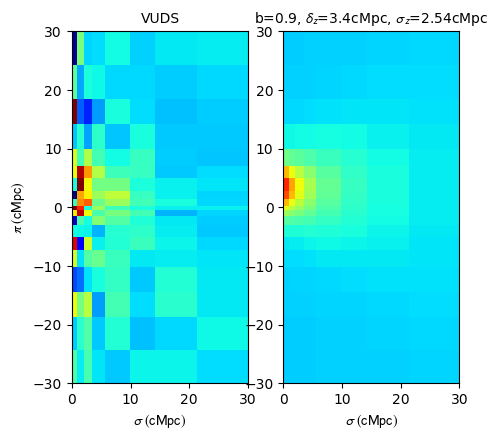

In [5]:
fitmodel_and_plotmin('VUDS')

Loading xcorr_zDeep_v4.npy
Loading covar_zDeep_v4_n7200.npy
(2., 3.16228, 2.7, 86.70233756, 'zDeep', '/Users/kheegan/lya/3d_recon/map2017/crosscorr/model_grid_v1/linear_cross_b2_s3.16228.txt')
Chi-squared = 86.702 for 203 dof


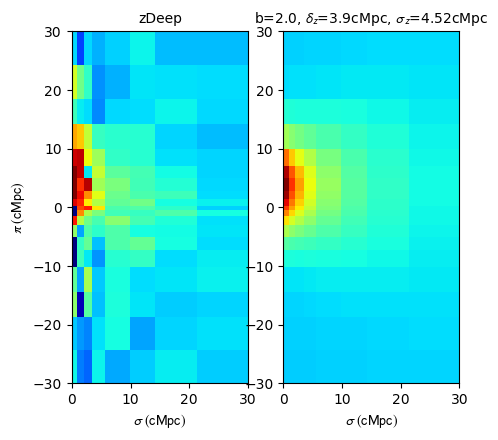

In [6]:
fitmodel_and_plotmin('zDeep')

Loading xcorr_MOSDEF_v4.npy
Loading covar_MOSDEF_v4_n7200.npy
(1.5, 0.794328, 0.8, 107.79042619, 'MOSDEF', '/Users/kheegan/lya/3d_recon/map2017/crosscorr/model_grid_v1/linear_cross_b1.5_s0.794328.txt')
Chi-squared = 107.790 for 203 dof


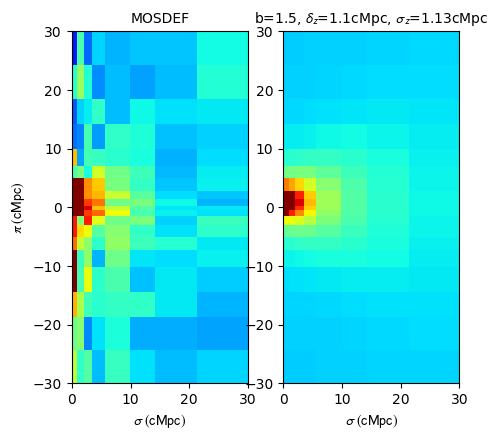

In [7]:
fitmodel_and_plotmin('MOSDEF')

Loading xcorr_CLAMATO_v4.npy
Loading covar_CLAMATO_v4_n7200.npy
(2.4, 1.41254, 1.2, 93.28130655, 'CLAMATO', '/Users/kheegan/lya/3d_recon/map2017/crosscorr/model_grid_v1/linear_cross_b2.4_s1.41254.txt')
Chi-squared = 93.281 for 203 dof


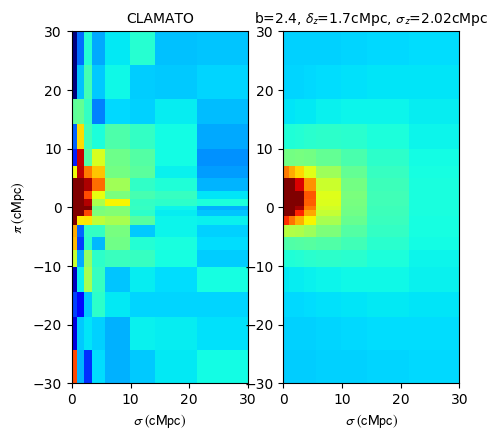

In [8]:
fitmodel_and_plotmin("CLAMATO")

Loading xcorr_3DHST_v4.npy
Loading covar_3DHST_v4_n7200.npy
(0.8, 4.46684, -1.5, 72.04938062, '3DHST', '/Users/kheegan/lya/3d_recon/map2017/crosscorr/model_grid_v1/linear_cross_b0.8_s4.46684.txt')
Chi-squared = 72.049 for 203 dof


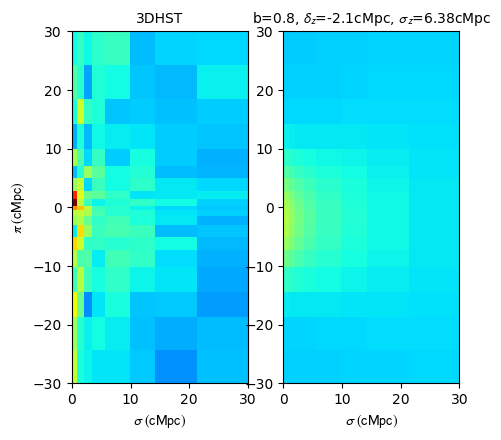

In [9]:
fitmodel_and_plotmin("3DHST")